# **Analyzing Customer Data for a Telecom Company to Predict Churn**

## **Introduction: Project Scope & Purpose**

Our dataset tracks a telco company's customer churn based on a variety of possible factors. Churn means that the customer ended up cancelling their service with the telco company. Our question is: **Can we predict whether a customer will churn by analyzing their relationship with the company?** By building a classification and regression model that predicts whether a customer will churn, the company will have data regarding which customers might churn, and why. The company may use this information to determine to which customers they must allocate resources towards, to minimize churn. This data can be used to make decisions regarding the application of deals or promotions, to maximize their business.

This dataset mostly contains categorical variables such as whether or not a customer is a senior citizen, has phone/internet service, etc. There are a few numeric variables, such as tenure (the number of months the customer has been with the firm) as well as their monthly and total charges paid to the company. The outcome variable is also categorical, churn, and has 2 categories: Yes or No. We need to construct a model with good predictive accuracy when most of our predictors are categorical variables. We will discuss how we approach this challenge in the **Method** section.

## **Preliminary Exploratory Data Analysis**

We begin this process by reading our raw data from its' web source into R. We do so below:

In [32]:
set.seed(1984)
library(tidyverse)
library(tidymodels)
library(readxl)

In [33]:
url <- "https://public.dhe.ibm.com/software/data/sw-library/cognos/mobile/C11/data/CustomerChurn.xlsx"

download.file(url, "Churn_Data.xlsx")

churn_data <- read_excel("Churn_Data.xlsx")
head(churn_data)

LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,⋯,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,⋯,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,⋯,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
845894,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,⋯,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
503388,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
160192,9305-CDSKC,No,No,No,8,Yes,Yes,Fiber optic,No,⋯,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


We are fortunate enough that our data is already mostly in tidy format, and what remains is to change the categorization of certain varibles (e.g. from "chr" to "fct") as well as make sure the columns include periods instead of spaces.

In [34]:
colnames(churn_data) <- make.names(colnames(churn_data))

In [35]:
churn_data_vars <- churn_data %>%
    mutate(across(Senior.Citizen:Dependents, as.factor))%>%
    mutate(across(Phone.Service:Payment.Method,as.factor))%>%
    mutate(Churn=as.factor(Churn))
head(churn_data_vars)


LoyaltyID,Customer.ID,Senior.Citizen,Partner,Dependents,Tenure,Phone.Service,Multiple.Lines,Internet.Service,Online.Security,⋯,Device.Protection,Tech.Support,Streaming.TV,Streaming.Movies,Contract,Paperless.Billing,Payment.Method,Monthly.Charges,Total.Charges,Churn
<dbl>,<chr>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,⋯,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,⋯,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
845894,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,⋯,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
503388,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,⋯,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
160192,9305-CDSKC,No,No,No,8,Yes,Yes,Fiber optic,No,⋯,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


In [36]:
#Splitting data into training and testing purposes
churn_split <- initial_split(churn_data_vars, prop=0.75, strata=Churn)
churn_train <- training(churn_split)
churn_test <- testing(churn_split)

## **Summarizing Our Data in a Table**

Given that we both have quantitative and categorical data, it is hard to summarize the whole dataset in one table, so we will be doing several, each analyzing different variables. Feel free to refer to the 1st section of the **Methods** portion of our proposal for our explanation for why we chose these variables

In [37]:
#Analyzing tenure and monthly charges by churn and non-churn customers
churn_tenure_charge <-churn_train %>%
    group_by(Churn)%>%
    summarise(across(c("Tenure", "Monthly.Charges"), mean))%>%
    rename(Mean.Tenure=Tenure)%>%
    rename(Mean.Monthly.Charges=Monthly.Charges)
    
churn_tenure_charge

`summarise()` ungrouping output (override with `.groups` argument)



Churn,Mean.Tenure,Mean.Monthly.Charges
<fct>,<dbl>,<dbl>
No,37.49601,61.14415
Yes,18.22040,74.82874


In [38]:
#Analyzing which proportion of customers are senior citizens, have a phone service, or have an internet service (Yes = they fall into that category)

senior_share <-churn_train %>%
       count(Senior.Citizen) %>%
       mutate(Yes_No=Senior.Citizen,)%>%
        relocate(Yes_No)

phone_service_share <-churn_train %>%
       count(Phone.Service)%>%
        mutate(Yes_No=Phone.Service,)%>%
        relocate(Yes_No)

internet_service_share <-churn_train %>%
    mutate(Internet.Service=as.character(Internet.Service))%>%
    mutate(Internet.Service=replace(Internet.Service, Internet.Service=="DSL", "Yes")) %>%
    mutate(Internet.Service=replace(Internet.Service, Internet.Service=="Fiber optic", "Yes"))%>%
    count(Internet.Service)%>%
    mutate(Yes_No= Internet.Service)%>%
        relocate(Yes_No)


customer_share <- senior_share %>%
    full_join(phone_service_share, by="Yes_No")%>%
    full_join(internet_service_share, by="Yes_No")%>%
    select(Yes_No,n.x,n.y,n)%>%
    rename("Senior Citizen"=n.x)%>%
    rename("Phone.Service"=n.y)%>%
    rename("Internet.Service"=n)
    
customer_share

Yes_No,Senior Citizen,Phone.Service,Internet.Service
<chr>,<int>,<int>,<int>
No,4433,510,1127
Yes,850,4773,4156


In [39]:
#Looking at customer contract distribution

contract_share <- churn_train %>%
    count(Contract)
contract_share

Contract,n
<fct>,<int>
Month-to-month,2923
One year,1089
Two year,1271


In [40]:
#Looking at customer payment method distribution

payment_share <- churn_train %>%
    count(Payment.Method)
payment_share

Payment.Method,n
<fct>,<int>
Bank transfer (automatic),1163
Credit card (automatic),1131
Electronic check,1776
Mailed check,1213


## **Visualizing Data**

Here we look at the distribution of tenure between current and churned customers.

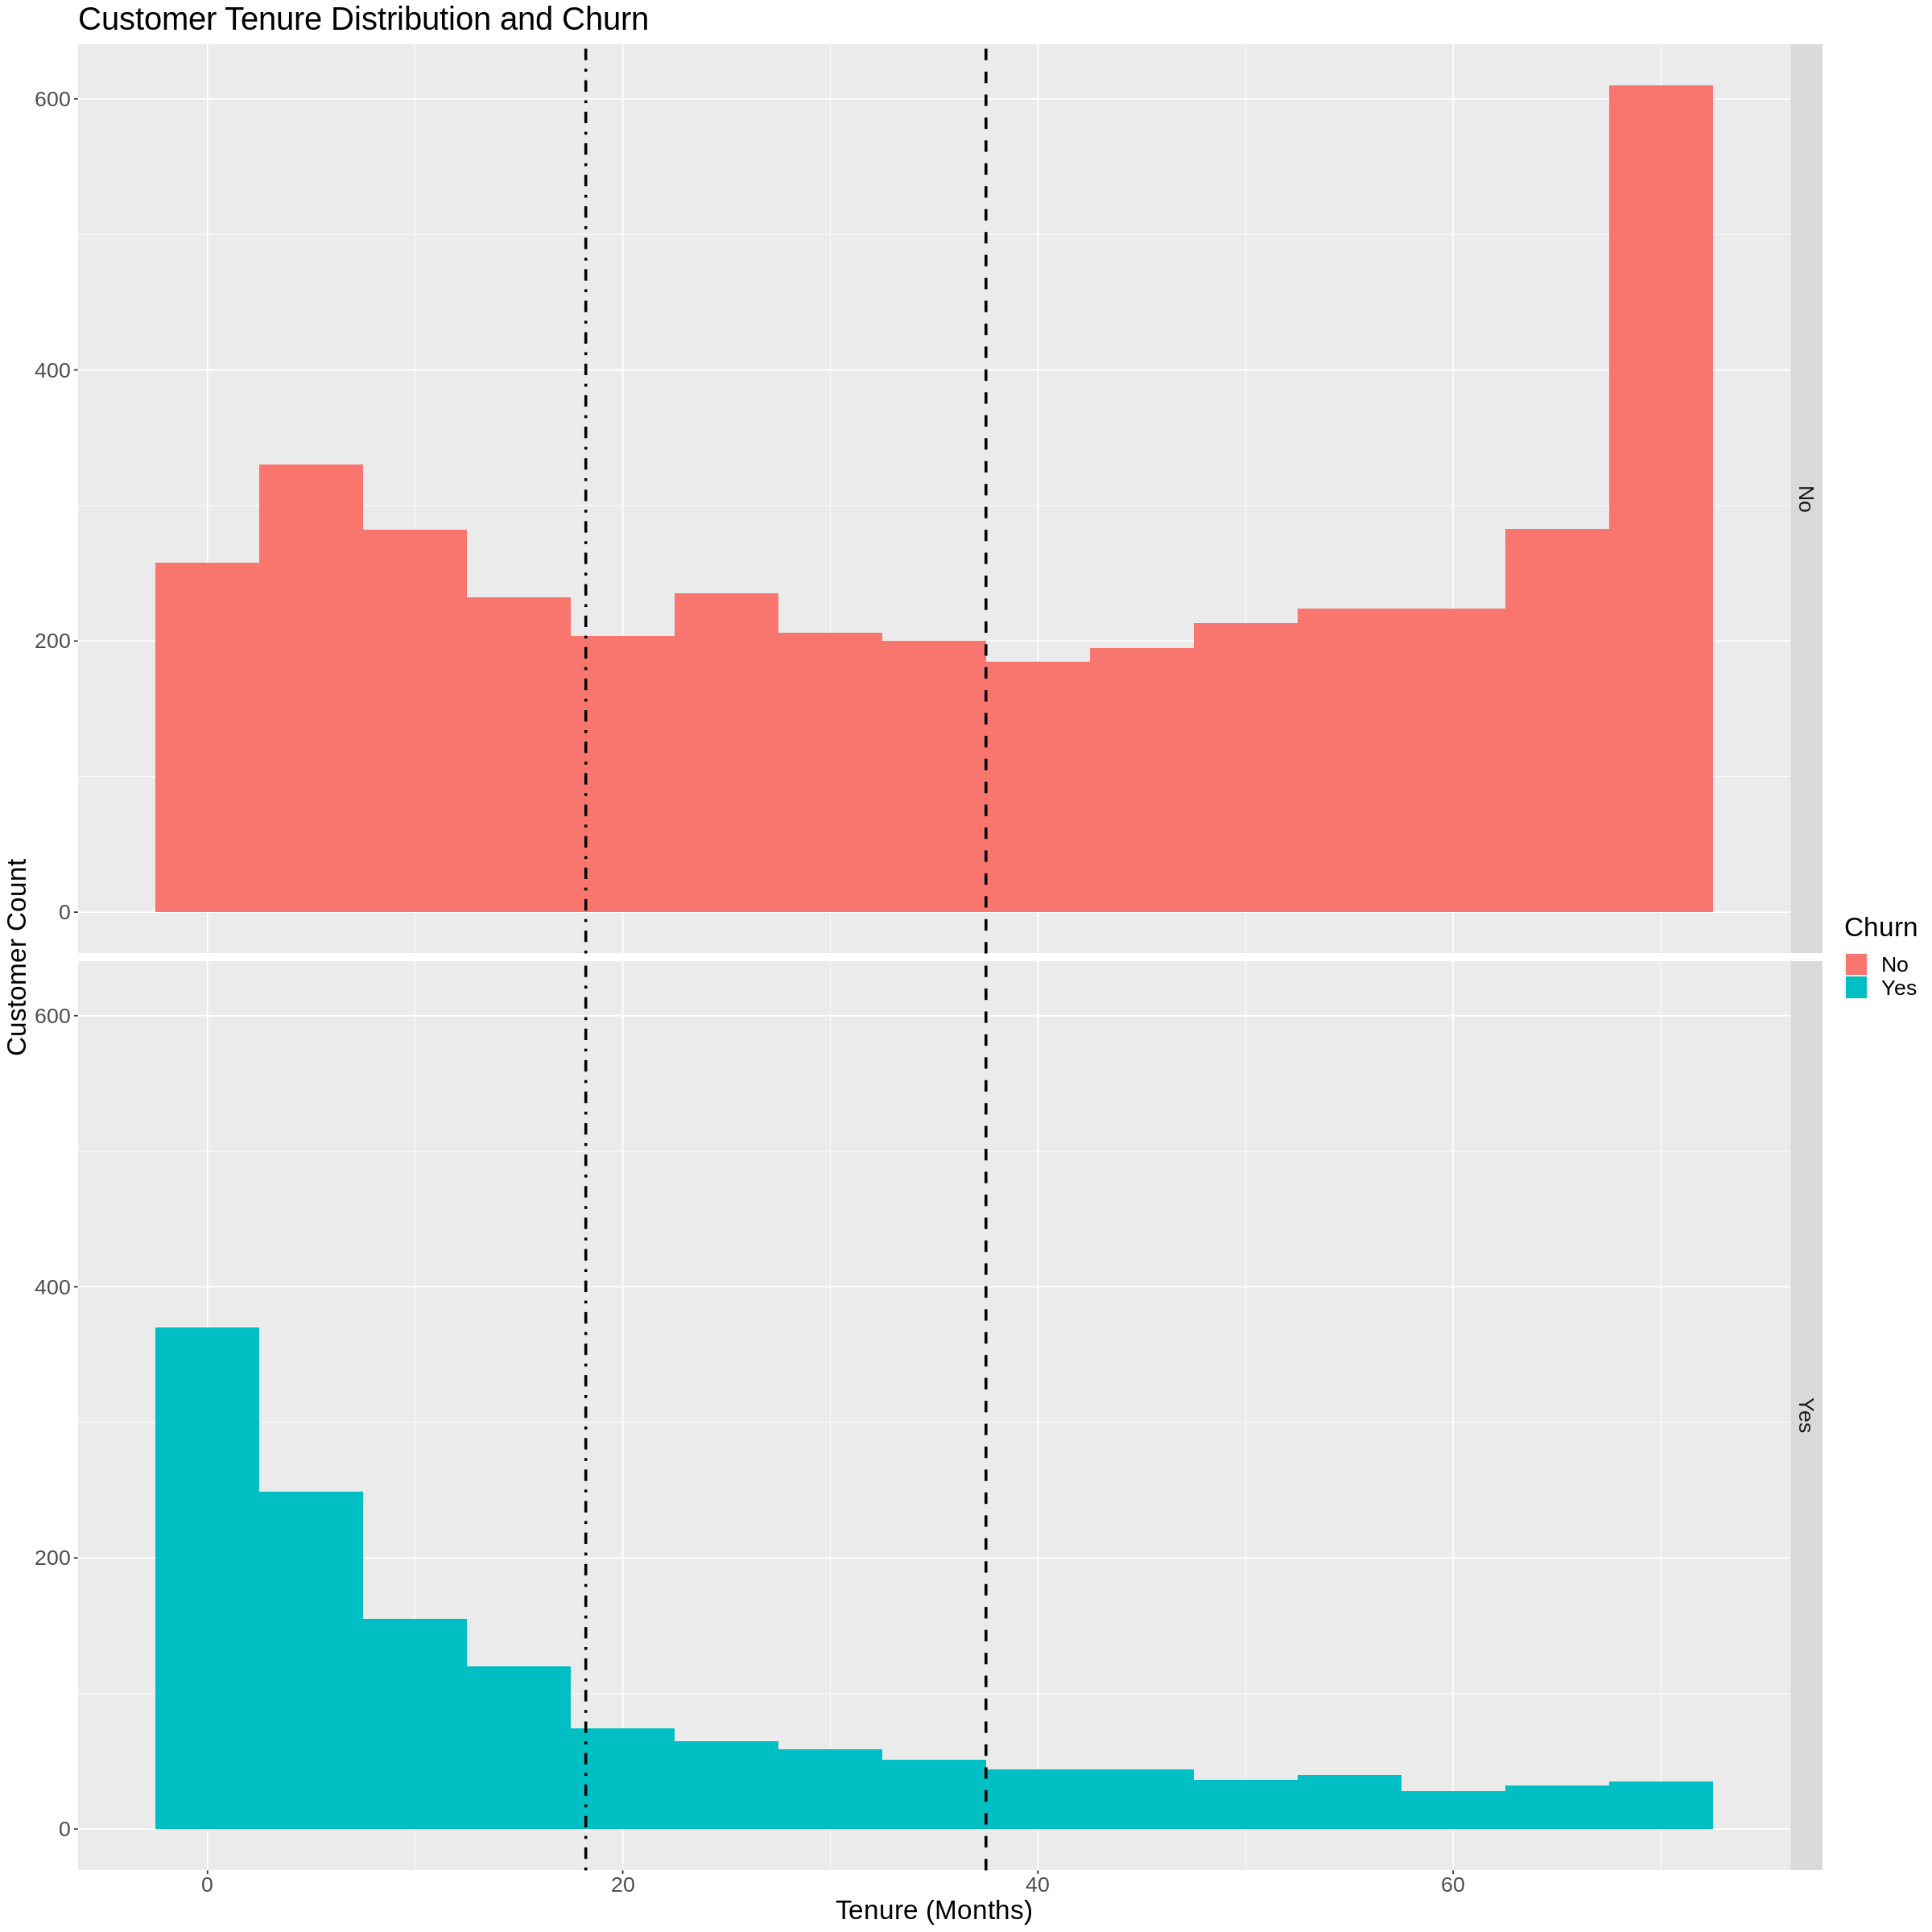

In [41]:
options(repr.plot.width = 20, repr.plot.height = 20)

tenure_dist <- churn_train %>%
    ggplot(aes(x=Tenure, fill=Churn))+
    geom_histogram(position="identity", binwidth=5)+
    facet_grid(Churn ~.)+
    theme(text=element_text(size=20))+
    labs(x="Tenure (Months)",y="Customer Count",fill="Churn")+
    ggtitle("Customer Tenure Distribution and Churn")+
    geom_vline(xintercept=pull(filter(churn_tenure_charge,Churn=="No"),Mean.Tenure),linetype="dashed",size=1.0)+
    geom_vline(xintercept=pull(filter(churn_tenure_charge,Churn=="Yes"),Mean.Tenure),linetype="dotdash",size=1.0)

tenure_dist

#dotdash = mean for churned customers, dash= mean for current customers


## **Methods**

We have chosen 7 predictor variables: 
* Tenure
* Phone Service
* Internet Service
* Contract
* Payment Method
* Monthly Charges
* Senior Citizen

Monthly charges are important as it can be a large expense for customers. Phone/Internet service is why the customer signed with the telco company in the first place. Tenure measures how long (in months) the customer has been with the company (shows customer loyalty). Lastly, we believe senior citizens may be less likely to churn as they may not be as technologically concerned as younger customers.

Contract type (monthly, yearly, two-year) is important as it shows how committed the customer is to the telco company. Payment is important because automatic transfers may have a lower psychological impact on retention.

To conduct our analysis, we will transform the categorical variables into dummy variables (this is where they are represented numerically in order to be able to regress it against a quantitative outcome variable), and conduct a linear regression with model specifications: 

$Churn_i$ = $\beta_0 + \beta_1senior.citizen_i + \beta_2 contract_i + ... + \epsilon_i$

If the linear regression returns a statistically significant p-value ($\alpha$ = 0.05), then we would select this variable in our prediction model. After we select our variables, we will build a predictive linear regression (0 = no churn, 1 = churn) and classification model (churn vs. no churn).

Note: In our proposal, we have chosen variables that we believe will be significant, but this may change after our analysis of statistical significance.

We can visualize our results by constructing a correlation matrix between the predictor variables as well as the outcome variables for our linear regression. For our classification model we can pick two variables and show how well the predicted outcomes mirror the true outcomes for churn


## **Expected Outcomes and Significance**

We will determine which variables impact churn. Given our preliminary analysis, we believe the customer tenure (# of months the customer has stayed with the firm) will have predictive power. Using our linear regression model, we can determine which of the other variables have predictive power.

By determining which variables predict churn, this will help the the company understand which customers it needs to focus its resources on to reduce churn. The company would be able to implement a proactive strategy of addressing customer needs before they want to leave the company.

Potential future questions:
* Which variable is most responsible for churn?
* How can the company reduce churn for its senior citizen customers?
* Is the type of internet service offered relevant for churn?
* Will more customers churn if we increase monthly charges but enhance a certain service?